In [33]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet

In [91]:
import torch as pt

In [35]:
pt.__version__

'2.2.1'

In [36]:
#Long tensor
a=pt.tensor([[1,2],[3,4]])

In [37]:
a

tensor([[1, 2],
        [3, 4]])

In [38]:
a.shape

torch.Size([2, 2])

In [39]:
a.type()

'torch.LongTensor'

In [40]:
#Float tensor
b=pt.tensor([[1,2],[3,4]],dtype=pt.float32)

In [41]:
b.type()

'torch.FloatTensor'

In [42]:
#Double tensor
c=pt.tensor([[1,2],[3,4]],dtype=pt.float64)

In [43]:
c.type()

'torch.DoubleTensor'

In [44]:
#Half tensor
d=pt.tensor([[1,2],[3,4]],dtype=pt.float16)

In [45]:
d.type()

'torch.HalfTensor'

In [46]:
#se pueden hacer operaciones aritméticas normales
a*2

tensor([[2, 4],
        [6, 8]])

In [49]:
#si quisiera aplanar el tensor original debería hacer
# a=a.flatten()
a.flatten()

tensor([1, 2, 3, 4])

In [48]:
a

tensor([[1, 2],
        [3, 4]])

In [53]:
# mi tensor anterior tenía una dimension de 2x2 ahora es de 4x1
b=a.reshape([1,1,2,2])

In [54]:
b.shape

torch.Size([1, 1, 2, 2])

In [55]:
#podría no especificar todos los elementos del reshape
b=a.reshape([1,1,-1,2])

In [56]:
b.shape

torch.Size([1, 1, 2, 2])

In [57]:
b

tensor([[[[1, 2],
          [3, 4]]]])

In [58]:
#Referirme a elementos del tensor
b[0]

tensor([[[1, 2],
         [3, 4]]])

In [59]:
b[0][0]

tensor([[1, 2],
        [3, 4]])

In [60]:
b[0][0][0]

tensor([1, 2])

In [61]:
b[0][0][0][0]
# b[0,0,0,0]

tensor(1)

In [62]:
a[0,0]

tensor(1)

In [63]:
#es otra forma de hacer reshape
a.view([1,-1])


tensor([[1, 2, 3, 4]])

In [64]:
a

tensor([[1, 2],
        [3, 4]])

## Segunda parte

### Con todo esto se contrulle la grafica

In [68]:
def compute():
    #si quiero tener en cuenta los gradientes de un tensor
    a=pt.tensor([3.],requires_grad=True)
    o=5*a**2
    return [a,o]


In [71]:
[a,o]=compute()
print(a)
print(o)

tensor([3.], requires_grad=True)
tensor([45.], grad_fn=<MulBackward0>)


 si voy backwards en "o" primero veo la multimplicación y luego la potencia

In [72]:
#Para computar los gradientes
#para hacer esto el valor final de o debe ser un escalar
#el backward es la derivada de o con respecto a a o sea 5*2*a
o.backward()
# para obtener el gradiente de a
print(a.grad)

tensor([30.])


que pasaria si hiciera las computaciones no en una funcion?

In [73]:
a=pt.tensor([3.],requires_grad=True)

In [78]:
#si lo computo otra vez el valor cambia porque se acumulan los gradientes
o=5*a**2
o.backward()
print(a.grad)

tensor([30.])


In [77]:
#por eso es importante resetear los gradientes
a.grad.zero_()

tensor([0.])

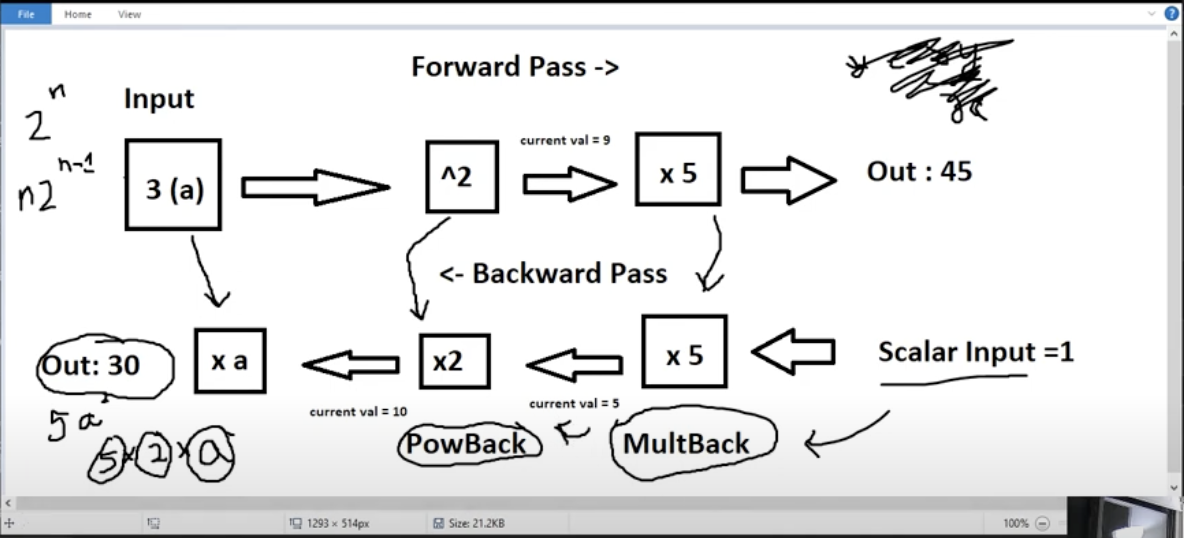

In [81]:
[a,o]=compute()
print(o.grad_fn)
o.grad_fn.next_functions

((<PowBackward0 at 0x17849cc40>, 0), (None, 0))

In [88]:
#Se llama la función de gradiente de o en temp y como se ve esta multiplication
#function lo que hace es multiplicar por 5
temp =  pt.tensor([1.])
o.grad_fn(temp)

(tensor([5.]), None)

In [89]:
#Es 6 porque como es la siguiente parte de la funcion sería 2*3 
o.grad_fn.next_functions[0][0](temp)

tensor([6.], grad_fn=<MulBackward0>)

In [90]:
#el ultimo paso sería
o.grad_fn.next_functions[0][0].next_functions

((<AccumulateGrad at 0x1782e9cc0>, 0),)

## Hallar gradientes, y cómo no hacerlo

In [104]:
x = pt.ones(3) #input
w = pt.randn(3,2,requires_grad=True) #matriz 2*3, para pesos
b = pt.randn(2,requires_grad=True) #matriz para bias
#para que no salga el error de Target size (torch.Size([1])) must be ...
z = pt.matmul(x,w)+b
y = pt.ones(2) #output
loss = pt.nn.functional.binary_cross_entropy_with_logits(z,y)
loss

tensor(0.4391, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

quiero mis gradientes con respecto al gradiente de perdida:<br>
dl/dw: pesos <br>
dl/db: bias

In [105]:
#
loss.backward()
print(w.grad)
print(b.grad)

tensor([[-0.2852, -0.0164],
        [-0.2852, -0.0164],
        [-0.2852, -0.0164]])
tensor([-0.2852, -0.0164])


que pasa si no necesito gradientes?

In [106]:
z=pt.matmul(x,w)+b
print(z.requires_grad)

True


In [107]:
with pt.no_grad():
    z=pt.matmul(x,w)+b
print(z.requires_grad)

False


In [108]:
z=pt.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# How to build neural netwoks

Hay varios contenedores: Module, sequential y ModuleList
Los Sequential son grafos que tienen varias capas en donde la 1 encaja en la 2, la 2 en la 3 y así sucesivamente. 1 input y 1 output

In [ ]:
#Cómo se define un modelo secuencial?
# nn.Sequential(las capas que quiero)

In [124]:
import torch.nn as nn

In [125]:
# Voy a crear una red simple con dos capas lienales y una ReLu en la mitad
#Toma un número como input y retorna un número por eso la priemra capa lienar tiene un 1
model = nn.Sequential(
    nn.Linear(1,10), #estas son fully conected
    nn.ReLU(),
    nn.Linear(10,1)
)

In [126]:
#1:dimension de las features
#2:el tamaño del batch
# en resumen, le paso 2 elementos con dimensión de 1 cada uno
model(pt.rand(2,1))

tensor([[-0.6417],
        [-0.6870]], grad_fn=<AddmmBackward0>)

In [127]:
#Implemento una función de loss porque quiero hacer back propagation
# el loss es un escalar
a=sum(model(pt.rand(2,1)))
a

tensor([-1.4163], grad_fn=<AddBackward0>)

In [128]:
#llamo a la backward function para hacer back propagation
a.backward()

In [129]:
#como se ven los parametros de mi modelo
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)>

In [130]:
#como hago para ver los pesos de mi modelo
model[0].weight

Parameter containing:
tensor([[-0.9564],
        [-0.7145],
        [-0.4309],
        [-0.4812],
        [-0.0229],
        [ 0.5946],
        [ 0.1676],
        [-0.0289],
        [-0.3924],
        [-0.1864]], requires_grad=True)

In [131]:
#para llamar al sesgo
model[0].bias

Parameter containing:
tensor([ 0.3027, -0.6822, -0.6813, -0.8283, -0.5932, -0.3266,  0.9832,  0.9941,
         0.4617,  0.2155], requires_grad=True)

In [132]:
#si quiero el gradiente de ese sesgo
model[0].bias.grad

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.3741, -0.5876,
        -0.4222,  0.4781])

In [133]:
model.zero_grad()

In [134]:
model[0].bias.grad

#### Entrenando el modelo manualmente

In [135]:
#ciclo de entrenamiento de la red
model = nn.Sequential(
    nn.Linear(1,10),
    nn.ReLU(),
    nn.Linear(10,1)
)
#datosrandom como ejemplo para entrenar
x=pt.rand(1000,1)
y=x**2
#con esto nos podemos dar cuenta que el objetivo de la red es aprender la función x^2
for i in range(30): #30 rondas de entrenamiento
    out = model(x)
    loss = pt.sum((out-y)**2)/1000 #esto es para calcular el error
    print (loss)
    loss.backward()
    #acumulo los gradientes
    dx1 = model[0].weight.grad #el gradiente de la primera capa (la linear)
    dx2 = model[2].weight.grad #el gradiente de la tercer capa (la linear)
    db1 = model[0].bias.grad #el gradiente del sesgo de la primera capa
    db2 = model[2].bias.grad #el gradiente del sesgo de la tercera capa
    #actualizo los pesos, el 0,01 lo pongo para que no sea tan grande el cambio, esa radom
    with pt.no_grad():
        model[0].weight -= 0.01*dx1
        model[2].weight -= 0.01*dx2
        model[0].bias -= 0.01*db1
        model[2].bias -= 0.01*db2
    model.zero_grad()

tensor(0.2734, grad_fn=<DivBackward0>)
tensor(0.2411, grad_fn=<DivBackward0>)
tensor(0.2132, grad_fn=<DivBackward0>)
tensor(0.1891, grad_fn=<DivBackward0>)
tensor(0.1682, grad_fn=<DivBackward0>)
tensor(0.1502, grad_fn=<DivBackward0>)
tensor(0.1345, grad_fn=<DivBackward0>)
tensor(0.1210, grad_fn=<DivBackward0>)
tensor(0.1093, grad_fn=<DivBackward0>)
tensor(0.0992, grad_fn=<DivBackward0>)
tensor(0.0905, grad_fn=<DivBackward0>)
tensor(0.0829, grad_fn=<DivBackward0>)
tensor(0.0763, grad_fn=<DivBackward0>)
tensor(0.0706, grad_fn=<DivBackward0>)
tensor(0.0657, grad_fn=<DivBackward0>)
tensor(0.0615, grad_fn=<DivBackward0>)
tensor(0.0578, grad_fn=<DivBackward0>)
tensor(0.0546, grad_fn=<DivBackward0>)
tensor(0.0518, grad_fn=<DivBackward0>)
tensor(0.0494, grad_fn=<DivBackward0>)
tensor(0.0473, grad_fn=<DivBackward0>)
tensor(0.0454, grad_fn=<DivBackward0>)
tensor(0.0438, grad_fn=<DivBackward0>)
tensor(0.0424, grad_fn=<DivBackward0>)
tensor(0.0412, grad_fn=<DivBackward0>)
tensor(0.0401, grad_fn=<D

In [138]:
# como se vería un output de mi modelo:
x = pt.rand(2,1)
print(x**2)
print(model(x))


tensor([[0.0120],
        [0.2909]])
tensor([[0.1602],
        [0.3336]], grad_fn=<AddmmBackward0>)


se puede ver que no es muy bueno

#### Entrenando el modelo con un optimizador

El optimizador ya se preocupa por los gradientes y demás, yo solo debo preocuparme por escoger el tipo de optimizador que quiero utilizar


In [139]:
#ciclo de entrenamiento de la red
model = nn.Sequential(
    nn.Linear(1,10),
    nn.ReLU(),
    nn.Linear(10,1)
)
#datosrandom como ejemplo para entrenar
x=pt.rand(1000,1)
y=x**2
optimizer = pt.optim.SGD(model.parameters(),lr=0.01)
for i in range(30): #30 rondas de entrenamiento
    out = model(x)
    loss = pt.sum((out-y)**2)/1000 #esto es para calcular el error
    print (loss)
    loss.backward()
    optimizer.step() #mueve los paramentros en la direccion del gradiente
    optimizer.zero_grad()


tensor(0.0852, grad_fn=<DivBackward0>)
tensor(0.0829, grad_fn=<DivBackward0>)
tensor(0.0809, grad_fn=<DivBackward0>)
tensor(0.0792, grad_fn=<DivBackward0>)
tensor(0.0776, grad_fn=<DivBackward0>)
tensor(0.0761, grad_fn=<DivBackward0>)
tensor(0.0748, grad_fn=<DivBackward0>)
tensor(0.0736, grad_fn=<DivBackward0>)
tensor(0.0725, grad_fn=<DivBackward0>)
tensor(0.0715, grad_fn=<DivBackward0>)
tensor(0.0705, grad_fn=<DivBackward0>)
tensor(0.0696, grad_fn=<DivBackward0>)
tensor(0.0688, grad_fn=<DivBackward0>)
tensor(0.0680, grad_fn=<DivBackward0>)
tensor(0.0672, grad_fn=<DivBackward0>)
tensor(0.0665, grad_fn=<DivBackward0>)
tensor(0.0658, grad_fn=<DivBackward0>)
tensor(0.0651, grad_fn=<DivBackward0>)
tensor(0.0644, grad_fn=<DivBackward0>)
tensor(0.0638, grad_fn=<DivBackward0>)
tensor(0.0631, grad_fn=<DivBackward0>)
tensor(0.0625, grad_fn=<DivBackward0>)
tensor(0.0619, grad_fn=<DivBackward0>)
tensor(0.0613, grad_fn=<DivBackward0>)
tensor(0.0607, grad_fn=<DivBackward0>)
tensor(0.0602, grad_fn=<D

In [140]:
# como se vería un output de mi modelo:
x = pt.rand(2,1)
print(x**2)
print(model(x))

tensor([[0.1073],
        [0.5472]])
tensor([[0.2934],
        [0.4060]], grad_fn=<AddmmBackward0>)


In [141]:
#podría entrenar con 50 rondas
#ciclo de entrenamiento de la red
model = nn.Sequential(
    nn.Linear(1,10),
    nn.ReLU(),
    nn.Linear(10,1)
)
#datosrandom como ejemplo para entrenar
x=pt.rand(1000,1)
y=x**2
optimizer = pt.optim.SGD(model.parameters(),lr=0.01)
for i in range(50): #30 rondas de entrenamiento
    out = model(x)
    loss = pt.sum((out-y)**2)/1000 #esto es para calcular el error
    loss.backward()
    optimizer.step() #mueve los paramentros en la direccion del gradiente
    optimizer.zero_grad()


In [142]:
# como se vería un output de mi modelo:
x = pt.rand(2,1)
print(x**2)
print(model(x))

tensor([[0.4443],
        [0.1112]])
tensor([[0.2468],
        [0.2796]], grad_fn=<AddmmBackward0>)
